In [19]:
import datetime

In [20]:
import math
import os
import time

In [21]:
from collections import deque
from collections.abc import Iterable
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

In [22]:
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.utils import data

import yolact

In [23]:
from siim import bootstrap, io
from siim.config import cfg
from siim.resource import WEIGHTS_DIR_PATH, ScatterWrapper, TrainDataset
from yolact.data import detection_collate
from yolact.utils.augmentations import BaseTransform, SSDAugmentation
from yolact.utils.functions import MovingAverage, SavePath

In [24]:
def prepare_data(datum, device=torch.device('cpu')):
    images, (targets, masks, num_crowds) = datum
    images = Variable(images.to(device), requires_grad=False)
    targets = [Variable(ann.to(device), requires_grad=False)
               for ann in targets]
    masks = [Variable(mask.to(device), requires_grad=False) for mask in masks]

    return images, targets, masks, num_crowds

In [25]:
def set_lr(optimizer, new_lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr

In [26]:
bootstrap()

In [27]:
dataset = TrainDataset(transform=SSDAugmentation(), empty_mask_is_negative=True)
n_samples = len(dataset) # n_samples is 60000
train_size = int(n_samples * 0.8) # train_size is 48000
val_size = n_samples - train_size # val_size is 48000
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

TypeError: Invalid shape (1, 550, 550) for image data

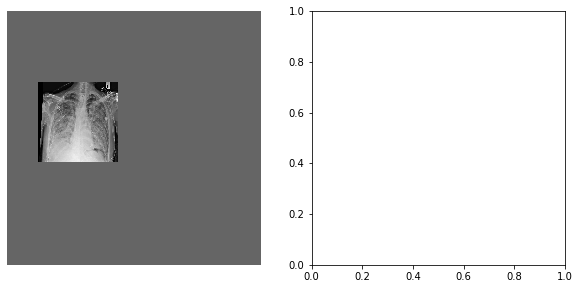

In [8]:
img, (target, mask, no_crowd) = train_dataset[2900]
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(img[0], cmap="gray")
plt.axis("off")
#
plt.subplot(1, 2, 2)
plt.imshow(img[0] * mask, cmap="gray")
plt.axis("off")

In [28]:
net = yolact.yolact.Yolact()
net.train()
net.init_weights(backbone_path=str(WEIGHTS_DIR_PATH / cfg.backbone.path))

In [29]:
data_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=cfg.batch_size,
    num_workers=cfg.num_workers,
    shuffle=True,
    collate_fn=detection_collate,
    pin_memory=True,
)

optimizer = optim.SGD(
    net.parameters(), lr=cfg.lr, momentum=cfg.momentum, weight_decay=cfg.decay
)
criterion = yolact.layers.MultiBoxLoss(
    num_classes=cfg.num_classes,
    pos_threshold=cfg.positive_iou_threshold,
    neg_threshold=cfg.negative_iou_threshold,
    negpos_ratio=3,
)

In [30]:
save_path = lambda epoch, iteration: SavePath(cfg.name, epoch, iteration).get_path(root=cfg.save_folder)
time_avg = MovingAverage()
loss_types = ["B", "C", "M", "P", "D", "E", "S"]
loss_avgs = {k: MovingAverage(100) for k in loss_types}
print("Begin training!")

Begin training!


In [31]:
# try-except so you can use ctrl+c to save early and stop training
step_index = 0
iteration = 0
last_time = time.time()
epoch_size = len(train_dataset) // cfg.batch_size
num_epochs = math.ceil(cfg.max_iter / epoch_size)

for epoch in range(num_epochs):
    for datum in data_loader:
        # Stop if we've reached an epoch if we're resuming from start_iter
        if iteration == (epoch + 1) * epoch_size:
            break

        # Stop at the configured number of iterations even if mid-epoch
        if iteration == cfg.max_iter:
            break

        # Change a config setting if we've reached the specified iteration
        changed = False
        for change in cfg.delayed_settings:
            if iteration >= change[0]:
                changed = True
                cfg.replace(change[1])

                # Reset the loss averages because things might have changed
                for avg in loss_avgs:
                    avg.reset()

        # If a config setting was changed, remove it from the list so we don't keep checking
        if changed:
            cfg.delayed_settings = [
                x for x in cfg.delayed_settings if x[0] > iteration]

        # Warm up by linearly interpolating the learning rate from some smaller value
        if cfg.lr_warmup_until > 0 and iteration <= cfg.lr_warmup_until:
            set_lr(optimizer, (cfg.lr - cfg.lr_warmup_init) *
                   (iteration / cfg.lr_warmup_until) + cfg.lr_warmup_init)

        # Adjust the learning rate at the given iterations, but also if we resume from past that iteration
        while step_index < len(cfg.lr_steps) and iteration >= cfg.lr_steps[step_index]:
            step_index += 1
            set_lr(optimizer, args.lr * (args.gamma ** step_index))

        # Load training data
        # Note, for training on multiple gpus this will use the custom replicate and gather I wrote up there
        images, targets, masks, num_crowds = prepare_data(datum)

        # Forward Pass
        out = net(images)

        # Compute Loss
        optimizer.zero_grad()

        wrapper = ScatterWrapper(targets, masks, num_crowds)
        losses = criterion(out, wrapper, wrapper.make_mask())

        # Mean here because Dataparallel
        losses = {k: v.mean() for k, v in losses.items()}
        loss = sum([losses[k] for k in losses])

        # Backprop
        loss.backward()  # Do this to free up vram even if loss is not finite
        if torch.isfinite(loss).item():
            optimizer.step()

        # Add the loss to the moving average for bookkeeping
        for k in losses:
            loss_avgs[k].add(losses[k].item())

        cur_time = time.time()
        elapsed = cur_time - last_time
        last_time = cur_time

        # Exclude graph setup from the timing information
        if 0 < iteration:
            time_avg.add(elapsed)

        if iteration % 10 == 0:
            eta_str = str(datetime.timedelta(
                seconds=(cfg.max_iter-iteration) * time_avg.get_avg())).split('.')[0]

            total = sum([loss_avgs[k].get_avg() for k in losses])
            loss_labels = sum([[k, loss_avgs[k].get_avg()]
                               for k in loss_types if k in losses], [])

            print(('[%3d] %7d ||' + (' %s: %.3f |' * len(losses)) + ' T: %.3f || ETA: %s || timer: %.3f')
                  % tuple([epoch, iteration] + loss_labels + [total, eta_str, elapsed]), flush=True)

        iteration += 1

        if iteration % cfg.save_interval == 0 and 0 < iteration:
            print('Saving state, iter:', iteration)
            net.save_weights(save_path(epoch, iteration))

            #if cfg.keep_latest:
            #    for p in SavePath.get_olds(cfg.save_folder, cfg.name):
            #        print('Deleting old save...')
            #        os.remove(str(p))
            
        break
    break

net.save_weights(save_path(epoch, iteration))

[  0]       0 || B: 9553.233 | C: 4.514 | M: 0.000 | S: 0.524 | T: 9558.272 || ETA: 0:00:00 || timer: 124.124
